# Configurations

In [1]:
import os
from os.path import join
import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame as dataframe


!export PYTHONPATH="/home/hendrio/amex-1M/:$PYTHONPATH"
!export PYTHONPATH="/home/hendrio/amex-1M/src/:$PYTHONPATH"


import sys
sys.path.append('/home/hendrio/amex-1M/')
sys.path.append('/home/hendrio/amex-1M/src/')

In [2]:
root_dir ="/"
base_dir = join('/', 'home', 'hendrio', 'amex-1M')
paths = {
    'root':root_dir,
    'base': base_dir,
    'data': join(base_dir, 'data'), 
    'resources': join(base_dir, 'resources'), 
    'processed': join(base_dir, 'data', 'processed'),
    'temp': join(base_dir, 'data', 'temp'),
    'dataset': join(root_dir, 'home', 'joner', 'SF23-AMExplorer-dev', 'output_1M_amexplorer')
}

In [3]:
files = dataframe(os.listdir(paths['dataset']),columns=['files']).sort_values(by=['files']).reset_index(drop=True)
files

,files
0,VT_MALICIOUS.csv
1,VT_metadata.csv
2,VT_metadata.rar
3,binary_dataset_apicalls.npz
4,binary_dataset_apicalls_1.npz
5,binary_dataset_apicalls_10.npz
6,binary_dataset_apicalls_11.npz
7,binary_dataset_apicalls_12.npz
8,binary_dataset_apicalls_13.npz
9,binary_dataset_apicalls_14.npz


## Functions

In [4]:
import re

def modify_column(df, column, feature_name='apicall'):

    def modify_string(s):
        # Replace '_' with '::'
        s = s.lower()
        s = s.replace('_', '::', 1)
        s = s.replace('.', '/')
        s = s[::-1].replace('/', '.', 1)[::-1]
        s = s.replace(f'{feature_name}::', f'{feature_name}s::')
        s = s.replace('()', '')
        # Replace the last '/' with '.'
        # modified_str = re.sub(r'/(?!.*\/)', '.', s)
        return s
    
    df[column] = df[column].apply(modify_string)
    return df

def get_indexers_for_list(df, column, values_list):
    """
    Returns the indexers of column values that are present in a given list.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be checked.
    column (str): The name of the column to be checked.
    values_list (list): The list of values to check against.

    Returns:
    list: A list of indices where the column values are present in the given list.
    """
    # Get the indexers for the values present in the given list
    indexers = df.index[df[column].isin(values_list)].tolist()
    return indexers


def features_names_transform(df_features, feature_types = ['apicall', 'permission', 'intent']):

    feature_dict = {}
    for f in feature_types:
        feature_dict[f] = df_features[df_features['feature'].str.contains(f"{f}::")].values.squeeze()
    
    return feature_dict


def get_intersection(df1, df2, column):
    common_features = set(df1[column]).intersection(set(df2[column]))
    return df1[df1[column].isin(common_features)]

def filter_data(data, df_features):
    return data[:, df_features.index]

def load_raw(path_dict, feature_name, feature_filter=None, path_save=None):
    raw_dict = np.load(path_dict)

    raw_features = modify_column(
            df=dataframe(raw_dict['unique_features'], columns=['feature']), 
            column='feature',
            feature_name=feature_name
        )
    # intent_features['feature'] = intent_features['feature'].str.replace('intents', 'intent', 1)
    print(raw_dict.keys())
    
    print('Input shape:', raw_dict['dataset'].dtype, raw_dict['dataset'].shape)

    if feature_filter is None:
  
        if path_save is not None:
            # file_name= join(base_dir, 'data', 'dataset', 'binary_dataset_intents')
            np.save(f'{path_save}.npy', data)
            df_features_filter.to_csv(f'{path_save}.csv', index=False)
            # return None
        
        return raw_dict['dataset'], raw_dict['unique_features']
    
    else:
        df_features_filter = get_intersection(df1=raw_features, df2=feature_filter, column='feature')

        data = filter_data(
            data=raw_dict['dataset'], 
            df_features=df_features_filter
        )
    
        print('New input shape:', data.dtype, data.shape)

        if path_save is not None:
            # file_name= join(base_dir, 'data', 'dataset', 'binary_dataset_intents')
            np.save(f'{path_save}.npy', data)
            df_features_filter.to_csv(f'{path_save}.csv', index=False)
            # return None
            
        return data, df_features_filter['feature'].values

## MH100 Features

In [5]:
## mh100 features

mh100_features  = pd.read_csv('mh100-features-all.csv', index_col=0).reset_index(drop=True)
mh100_features['features'] = mh100_features['features'].str.lower() 
mh100_features['features'] = mh100_features['features'].str.replace('()', '') 
mh100_features.rename(columns={'features':'feature'}, inplace=True)
mh100_features

,feature
0,permissions::wake_lock
1,permissions::write_external_storage
2,permissions::access_network_state
3,permissions::write_settings
4,permissions::internet
...,...
24828,apicalls::landroid/widget/tablerow.getleft
24829,apicalls::landroid/widget/horizontalscrollview...
24830,apicalls::landroid/widget/ratingbar.isfocusable
24831,apicalls::landroid/preference/listpreference.g...


In [8]:
features_dict = features_names_transform(
    df_features=mh100_features, 
    feature_types = ['apicalls', 'permissions', 'intents']
)

print(features_dict.keys())

dict_keys(['apicalls', 'permissions', 'intents'])


In [9]:
features_dict['apicalls']

array(['apicalls::landroid/content/intent.touri',
       'apicalls::landroid/view/view.settag',
       'apicalls::landroid/util/xml.newserializer', ...,
       'apicalls::landroid/widget/ratingbar.isfocusable',
       'apicalls::landroid/preference/listpreference.getview',
       'apicalls::landroid/widget/linearlayout.computehorizontalscrollextent'],
      dtype=object)

In [10]:
mh100_apicalls = dataframe(features_dict['apicalls'], columns=['feature'])
mh100_apicalls

,feature
0,apicalls::landroid/content/intent.touri
1,apicalls::landroid/view/view.settag
2,apicalls::landroid/util/xml.newserializer
3,apicalls::landroid/content/pm/packagemanager.q...
4,apicalls::landroid/view/viewstub.setlayoutreso...
...,...
24412,apicalls::landroid/widget/tablerow.getleft
24413,apicalls::landroid/widget/horizontalscrollview...
24414,apicalls::landroid/widget/ratingbar.isfocusable
24415,apicalls::landroid/preference/listpreference.g...


In [9]:
mh100_intents = dataframe(features_dict['intent'], columns=['feature'])
mh100_intents

KeyError: 'intent'

In [11]:
mh100_permissions = dataframe(features_dict['permission'], columns=['feature'])
mh100_permissions

,feature
0,permission::wake_lock
1,permission::write_external_storage
2,permission::access_network_state
3,permission::write_settings
4,permission::internet
...,...
161,permission::read_precise_phone_state
162,permission::bluetooth_advertise
163,permission::high_sampling_rate_sensors
164,permission::bind_autofill_service


# Process RAW dataset

In [12]:
def process_amex(path, n_chunks=14, sufix_name='binary_dataset_apicalls_', feature_filter=None, path_save=None):

    dataset = []
    sha256 = []
    for idx in tqdm.tqdm(range(1, n_chunks+1)):
        
        file_name = f'{sufix_name}{idx}.npz' 
        print(file_name)

        if path_save is not None and os.path.exists(join(path_save, f'{sufix_name}{idx}.npy')):
            print(f'{file_name} exists. Skipping.')
            continue
        
        # keys: dataset, sha256_list, unique_features
        # print('\tfile: ', join(path, file_name))
        try:
            np_dict__ = np.load(join(path, file_name))
            data__ = np_dict__['dataset']
            # print(data__.shape)
            sha256__ = np_dict__['sha256_list']
            unique_features__ = np_dict__['unique_features']

            print(f'\n data shape: {data__.shape}')
        except:
            print(f'Error in read {file_name}')
            continue
            
        if feature_filter is not None:
            
            raw_features = modify_column(
                df=dataframe(unique_features__, columns=['feature']), 
                column='feature',
                feature_name='apicall'
            )
            
            df_features_filter = get_intersection(
                df1=raw_features, df2=feature_filter, column='feature' )
            print(f'\tfeature shape: {raw_features.shape}, filtered features: {feature_filter.shape}, intersection: {df_features_filter.shape}')

            data__ = filter_data(
                data=data__, 
                df_features=df_features_filter)
    
            print('\tNew input shape:', data__.dtype, data__.shape)
            
        sha256.append(sha256__)
        
        if path_save is not None:
            if os.path.exists(join(path_save, f'{sufix_name}{idx}.npy')):
                continue
            # save data
            np.save(join(path_save, f'{sufix_name}{idx}.npy'), data__)
            # save sha256
            dataframe(sha256__, columns=['sha256']).to_csv(join(path_save, f'{sufix_name}sha256-{idx}.csv'), index=False)
            # save features
            if feature_filter is not None: 
                df_features_filter.to_csv(join(path_save, f'{sufix_name}{idx}.csv'), index=False)
            else:
                dataframe(unique_features__, columns=['features']).to_csv(join(path_save, f'{sufix_name}{idx}.csv'), index=False)
    
    return
    # return dataset, sha256, unique_features

## Process Raw API

In [13]:
mh100_apicalls.head()

,feature
0,apicall::landroid/content/intent.touri
1,apicall::landroid/view/view.settag
2,apicall::landroid/util/xml.newserializer
3,apicall::landroid/content/pm/packagemanager.qu...
4,apicall::landroid/view/viewstub.setlayoutresource


In [16]:
## process chunks of dataset
process_amex(
    path=paths['dataset'], 
    n_chunks=14, 
    sufix_name='binary_dataset_apicalls_',
    feature_filter=mh100_apicalls, 
    path_save=join('data', 'temp')
)

  0%|                                                                                                           | 0/14 [00:00<?, ?it/s]

binary_dataset_apicalls_1.npz
binary_dataset_apicalls_2.npz
binary_dataset_apicalls_3.npz
binary_dataset_apicalls_4.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 29%|████████████████████████████▎                                                                      | 4/14 [00:20<00:52,  5.23s/it]

binary_dataset_apicalls_5.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 36%|███████████████████████████████████▎                                                               | 5/14 [01:26<03:08, 20.99s/it]

binary_dataset_apicalls_6.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 43%|██████████████████████████████████████████▍                                                        | 6/14 [03:23<06:18, 47.36s/it]

binary_dataset_apicalls_7.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 50%|█████████████████████████████████████████████████▌                                                 | 7/14 [05:31<08:09, 69.99s/it]

binary_dataset_apicalls_8.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 57%|████████████████████████████████████████████████████████▌                                          | 8/14 [06:15<06:15, 62.58s/it]

binary_dataset_apicalls_9.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 64%|███████████████████████████████████████████████████████████████▋                                   | 9/14 [09:12<07:59, 95.85s/it]

binary_dataset_apicalls_10.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 71%|█████████████████████████████████████████████████████████████████████▎                           | 10/14 [11:21<07:02, 105.61s/it]

binary_dataset_apicalls_11.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 79%|█████████████████████████████████████████████████████████████████████████████                     | 11/14 [12:31<04:44, 94.85s/it]

binary_dataset_apicalls_12.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 12/14 [14:51<03:36, 108.34s/it]

binary_dataset_apicalls_13.npz

 data shape: (100000, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (100000, 22394)


 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 13/14 [15:46<01:32, 92.44s/it]

binary_dataset_apicalls_14.npz

 data shape: (48927, 66319)
	feature shape: (66319, 1), filtered features: (24417, 1), intersection: (22394, 1)
	New input shape: int8 (48927, 22394)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [16:13<00:00, 69.52s/it]


In [ ]:
# data = np.load(join(paths['dataset'], files['files'].iloc[16]))
# print(data.keys())
# # lst = data.files
# # for item in lst:
# #     print(item)
# #     print(data[item])

# print(np.asarray(data['unique_features']).shape)

# data['sha256_list'].shape
# arr = data['dataset'][0:10, :]

# modify_column(df=dataframe(data['unique_features'], columns=['feature']), 
#          column='feature')

## Load Chunks

In [21]:
def load_chunks(path, n_chunks=14, sufix_name='binary_dataset_apicalls_', path_save=None):

    data = []
    df_sha256 = pd.DataFrame()
    for idx in range(1, n_chunks+1):
        # print(idx)
        file_name = f"{sufix_name}{idx}.npy"
        file_path = os.path.join(path, file_name)
        features_path = os.path.join(path, f"{sufix_name}{idx}.csv")
        sha256_path = os.path.join(path, f"{sufix_name}sha256-{idx}.csv")
        
        if os.path.exists(file_path):
            print(file_name)
            arr = np.load(file_path)
            data.append(arr)

            csv_sha256 = pd.read_csv(sha256_path)
            df_sha256 = pd.concat([csv_sha256, df_sha256])

            column_names = pd.read_csv(features_path)

        else:
            print(f'file {file_name} not exists.')
            continue

    return np.concatenate(data), df_sha256.reset_index(drop=True), column_names


In [22]:
apicalls_data, sha256, apicalls_features = load_chunks(
    path=paths['temp'], 
    n_chunks=14, 
    sufix_name='binary_dataset_apicalls_', 
    path_save=None)

print(apicalls_data.shape, apicalls_data.dtype, sha256.shape)

binary_dataset_apicalls_1.npy
binary_dataset_apicalls_2.npy
binary_dataset_apicalls_3.npy
binary_dataset_apicalls_4.npy
binary_dataset_apicalls_5.npy
binary_dataset_apicalls_6.npy
binary_dataset_apicalls_7.npy
binary_dataset_apicalls_8.npy
binary_dataset_apicalls_9.npy
binary_dataset_apicalls_10.npy
binary_dataset_apicalls_11.npy
binary_dataset_apicalls_12.npy
binary_dataset_apicalls_13.npy
binary_dataset_apicalls_14.npy
(1348927, 22394) int8 (1348927, 1)


In [45]:
dataset.shape

(1348927, 22394)

In [26]:
len(np.unique(sha256['sha256']))

1348927

In [28]:
feature_names['feature'].values

array(['apicall::landroid/bluetooth/bluetootha2dp.getconnecteddevices',
       'apicall::landroid/bluetooth/bluetootha2dp.getconnectionstate',
       'apicall::landroid/bluetooth/bluetootha2dp.getdevicesmatchingconnectionstates',
       ..., 'apicall::landroid/window/splashscreenview.geticonview',
       'apicall::landroid/window/splashscreenview.getrootview',
       'apicall::landroid/window/splashscreenview.remove'], dtype=object)

In [29]:
# np.save(join(base_dir, 'data', 'dataset', 'binary_dataset_apicalls.npy'), dataset)
np.savez_compressed(
    join(base_dir, 'data', 'processed', 'amex_binary_data-[apicalls]'), 
    data=apicalls_data, 
    sha256=sha256['sha256'].values,
    feature_names=apicalls_features['feature'].values)

In [39]:
apicalls_features = feature_names['feature'].values

In [ ]:
sha256, column_names = load_chunks_features(
    path=paths['processed'], 
    n_chunks=14, 
    sufix_name='binary_dataset_apicalls_', 
    path_save=None)

In [ ]:
idx_features = get_indexers_for_list(df=df_features, column='feature', values_list=mh100_features['feature'].values)
print(idx_features[0:100])

In [ ]:
processed_features = modify_column(
    df=dataframe(column_names['features'].iloc[idx_features].values, columns=['features']),
    column='features'
)
processed_features

In [ ]:
processed_features.to_csv(join(base_dir, 'data', 'dataset', 'binary_dataset_apicalls_features.csv'), index=False)
sha256.to_csv(join(base_dir, 'data', 'dataset', 'binary_dataset_apicalls_sha256.csv'), index=False)
len(np.unique(sha256['sha256'].values))

# Process Intents, Opcodes, Permissions

In [6]:
def process_metadata(path, malware_column='VT_SCANNERS_MALICIOUS', threshold=4):
    metadata = pd.read_csv(path)
    metadata['VT_LAST_ANALYSIS_DATE'] = pd.to_datetime(metadata['VT_LAST_ANALYSIS_DATE'])
    metadata = metadata.sort_values('VT_LAST_ANALYSIS_DATE').drop_duplicates('SHA256', keep='last')
    # duplicate_values = metadata['SHA256'].duplicated()
    # metadata.drop_duplicates('SHA256', keep='last')
    
    metadata ['CLASS'] = create_class(df=metadata[malware_column], threshold=threshold)
    return metadata


def create_class(df, threshold):
    return np.asarray([1 if i>=threshold else 0 for i in df ])


def create_dataframe(raw_dict):

    raw_features = modify_column(
        df=pd.DataFrame(raw_dict['unique_features'], columns=['features']), 
        column='features',
        feature_name='intents'
    )
    print(raw_features.shape)
    data = dataframe(raw_dict['dataset'], columns=raw_features.values.squeeze())
    data['SHA256'] = raw_dict['sha256_list']

    return data

def merge_data_metadata(data, metadata, how='inner', on='SHA256'):
    feature_names = data.columns.values
    metadata_columns = metadata.columns.values
    print(metadata_columns)
    inner_data = data.merge(metadata, how=how, on=on)
    new_metadata = inner_data[metadata_columns]
    return inner_data.drop(columns=metadata_columns), new_metadata

def process_raw(path_npz, path_metadata, malware_column='VT_SCANNERS_MALICIOUS', threshold=4, path_save=None, dataset_name=None):
    
    raw_dict = np.load(
        path_npz, 
        allow_pickle=True
    )

    metadata = process_metadata(
        path=path_metadata, 
        malware_column=malware_column, 
        threshold=threshold
        )

    df_data = create_dataframe(raw_dict)
    
    dataset, dataset_metadata = merge_data_metadata(df_data, metadata)

    print(type(dataset), dataset.shape, dataset_metadata.shape)
    print()
    print(dataset_metadata['CLASS'].value_counts())
    print()
    # print(type(dataset), dataset_metadata.info())

    if path_save is not None:
        if dataset_name is None:
            raise Exception("You should provide the dataset name in parameter 'dataset_name'. ")
        
        print(f'saving in {join(path_save, f'{dataset_name}')}.npz')
        np.savez_compressed(
            join(path_save, f'{dataset_name}'), 
            data=dataset.values,
            column_names =  dataset.columns.values,
            metadata=dataset_metadata.values,
            metadata_columns = dataset_metadata.columns.values,
            classes =  dataset_metadata['CLASS'].values,
            sha256 = dataset_metadata['SHA256'].values
            )
    return dataset, dataset_metadata

In [7]:
files

,files
0,VT_MALICIOUS.csv
1,VT_metadata.csv
2,VT_metadata.rar
3,binary_dataset_apicalls.npz
4,binary_dataset_apicalls_1.npz
5,binary_dataset_apicalls_10.npz
6,binary_dataset_apicalls_11.npz
7,binary_dataset_apicalls_12.npz
8,binary_dataset_apicalls_13.npz
9,binary_dataset_apicalls_14.npz


### Intents

In [15]:
intent_data, intent_metadata = process_raw(
    path_npz=join(paths['dataset'], files['files'].iloc[19]), 
    path_metadata=join(paths['dataset'], files['files'].iloc[1]), 
    malware_column='VT_SCANNERS_MALICIOUS', 
    threshold=4,
    # path_save=paths['processed'], 
    # dataset_name='amex-1M-[intents]-v2'
    )

(407, 1)
['VT_LAST_ANALYSIS_DATE' 'VT_SIZE' 'SHA256' 'VT_MD5' 'VT_TIMES_SUBMITTED'
 'VT_SCANNERS_FAILURE' 'VT_SCANNERS_MALICIOUS' 'VT_SCANNERS_UNDETECTED'
 'VT_SCANNERS_SUGGESTED_THREAT_LABEL' 'VT_SCANNERS_NAMES' 'CLASS']
(1340515, 407) (1340515, 11)

CLASS
0    1221421
1     119094
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Data columns (total 11 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   VT_LAST_ANALYSIS_DATE               1340515 non-null  datetime64[ns]
 1   VT_SIZE                             1340515 non-null  float64       
 2   SHA256                              1340515 non-null  object        
 3   VT_MD5                              1340515 non-null  object        
 4   VT_TIMES_SUBMITTED                  1340515 non-null  int64         
 5   VT_SCANNERS_FAILURE                 1340515 non-null 

In [16]:
intent_metadata

,VT_LAST_ANALYSIS_DATE,VT_SIZE,SHA256,VT_MD5,VT_TIMES_SUBMITTED,VT_SCANNERS_FAILURE,VT_SCANNERS_MALICIOUS,VT_SCANNERS_UNDETECTED,VT_SCANNERS_SUGGESTED_THREAT_LABEL,VT_SCANNERS_NAMES,CLASS
0,2023-08-05 21:15:13,15576052.0,F0CCCE784B9CCE014B49D309373A64445994EBFBCCA59D...,d90c42db8299e0a8f4504580be3bdfc5,2,3,1,37,NaN,['SymantecMobileInsight'],0
1,2023-08-05 21:13:27,16874953.0,F0CCCEE4372536479010C93A63A7CF5A0C17DC147A88F6...,79cae7482063815784795b231822c8a8,1,0,0,64,NaN,[],0
2,2023-08-05 21:14:38,5366555.0,F0CCCFE09C1B6F4554F0786E23FEB706E320482D99B0E6...,3a75ebeda8ed1f49be929c8e5f28d59c,2,2,0,53,NaN,[],0
3,2023-08-05 21:09:19,4906525.0,F0CCD0627E09CF006004878283B24A763CE9703E2D91CD...,0a31f7d965e26a9c88615e95cadc0790,2,0,10,55,trojan.jiagu,"['Zillya', 'K7GW', 'Trustlook', 'SymantecMobil...",1
4,2023-08-05 21:09:53,19142337.0,F0CCD2984D49D859DA890814B30C35EFC4E4DDA23D78C6...,3d9bad0aa2c8c1d5ba1113ffcb794ca9,1,2,0,62,NaN,[],0
...,...,...,...,...,...,...,...,...,...,...,...
1340510,2023-09-05 18:16:22,10433169.0,FFFFFDF9B737730109BFE3A9EA0AB5970DD1F7E739F18E...,53bef80fd2a037f7c9947435cc565af0,1,0,0,65,NaN,[],0
1340511,2023-09-08 18:17:26,6715116.0,FFFFFE17C5D6AE624DC651BC17E9A69CC0B4ECD8AA2C9F...,95dcec107b479a86911bc36580101f94,1,0,0,64,NaN,[],0
1340512,2023-04-16 09:18:33,12615791.0,FFFFFE7879B772AC120FF701675F5242DAF608B891F7F3...,5d7e16208a4f23c72607085eacf403ee,1,0,0,63,NaN,[],0
1340513,2023-08-08 17:56:57,22476350.0,FFFFFFA028417FD71BE9C607D6F4F43B84D7D956575958...,c3a22979935e68bd671f305e91f309de,1,0,0,62,NaN,[],0


## Permissions

In [17]:
permission_data, permission_metadata = process_raw(
    path_npz=join(paths['dataset'], files['files'].iloc[23]), 
    path_metadata=join(paths['dataset'], files['files'].iloc[1]), 
    malware_column='VT_SCANNERS_MALICIOUS', 
    threshold=4,
    path_save=paths['processed'], 
    dataset_name='amex-1M-[permissions]-v2'
    )

(214, 1)
['VT_LAST_ANALYSIS_DATE' 'VT_SIZE' 'SHA256' 'VT_MD5' 'VT_TIMES_SUBMITTED'
 'VT_SCANNERS_FAILURE' 'VT_SCANNERS_MALICIOUS' 'VT_SCANNERS_UNDETECTED'
 'VT_SCANNERS_SUGGESTED_THREAT_LABEL' 'VT_SCANNERS_NAMES' 'CLASS']
(1340515, 214) (1340515, 11)

CLASS
0    1221421
1     119094
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Data columns (total 11 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   VT_LAST_ANALYSIS_DATE               1340515 non-null  datetime64[ns]
 1   VT_SIZE                             1340515 non-null  float64       
 2   SHA256                              1340515 non-null  object        
 3   VT_MD5                              1340515 non-null  object        
 4   VT_TIMES_SUBMITTED                  1340515 non-null  int64         
 5   VT_SCANNERS_FAILURE                 1340515 non-null 

In [25]:
print(permission_metadata['CLASS'].equals(intent_metadata['CLASS']))

print(permission_metadata.equals(intent_metadata))

True
True


## OpCodes

In [18]:
opcodes_data, opcodes_metadata = process_raw(
    path_npz=join(paths['dataset'], files['files'].iloc[21]), 
    path_metadata=join(paths['dataset'], files['files'].iloc[1]), 
    malware_column='VT_SCANNERS_MALICIOUS', 
    threshold=4,
    path_save=paths['processed'], 
    dataset_name='amex-1M-[opcodes]-v2'
    )

(232, 1)
['VT_LAST_ANALYSIS_DATE' 'VT_SIZE' 'SHA256' 'VT_MD5' 'VT_TIMES_SUBMITTED'
 'VT_SCANNERS_FAILURE' 'VT_SCANNERS_MALICIOUS' 'VT_SCANNERS_UNDETECTED'
 'VT_SCANNERS_SUGGESTED_THREAT_LABEL' 'VT_SCANNERS_NAMES' 'CLASS']
(1340515, 232) (1340515, 11)

CLASS
0    1221421
1     119094
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Data columns (total 11 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   VT_LAST_ANALYSIS_DATE               1340515 non-null  datetime64[ns]
 1   VT_SIZE                             1340515 non-null  float64       
 2   SHA256                              1340515 non-null  object        
 3   VT_MD5                              1340515 non-null  object        
 4   VT_TIMES_SUBMITTED                  1340515 non-null  int64         
 5   VT_SCANNERS_FAILURE                 1340515 non-null 

In [27]:
print(permission_metadata.equals(opcodes_metadata))

True


## APICalls

In [14]:
mh100_apicalls

,feature
0,apicalls::landroid/content/intent.touri
1,apicalls::landroid/view/view.settag
2,apicalls::landroid/util/xml.newserializer
3,apicalls::landroid/content/pm/packagemanager.q...
4,apicalls::landroid/view/viewstub.setlayoutreso...
...,...
24412,apicalls::landroid/widget/tablerow.getleft
24413,apicalls::landroid/widget/horizontalscrollview...
24414,apicalls::landroid/widget/ratingbar.isfocusable
24415,apicalls::landroid/preference/listpreference.g...


### Load Chunks

In [16]:
import gc
def load_apicalls_chunks(path, path_metadata, n_chunks=14, sufix_name='binary_dataset_apicalls_', features_filter=None, path_save=None, dataset_name=None):

    data = pd.DataFrame()
    metadata = pd.DataFrame()
    for idx in range(1, n_chunks+1):
        # print(idx)
        print('================================================================')
        file_name = f"{sufix_name}{idx}.npz"
        print(file_name)
        apicalls_data__ = np.load(
            join(path, file_name), 
            allow_pickle=True
        )

        print(apicalls_data__.keys())

        df_data_api = create_dataframe(apicalls_data__)
        print('\tshape: ', df_data_api.shape)

        if features_filter is not None:
            print('Filtering features: ')
            df_data_api = df_data_api[np.intersect1d(df_data_api.columns, features_filter)]
            print('\t new shape: ', df_data_api.shape)


        api__metadata = process_metadata(
            path=path_metadata, 
            malware_column='VT_SCANNERS_MALICIOUS', 
            threshold=4
            )
        
        api_chunck__, api_chunck__metadata__ = merge_data_metadata(
            data=df_data_api, 
            metadata=api__metadata,
            how='inner', on='SHA256')

        # np.array_equal(selected_features, selected_features)

        print(api_chunck__.shape, api_chunck__metadata__.shape)
        print()
        print(api_chunck__metadata__['CLASS'].value_counts())
        print()
        # print(type(api_chunck__), api_chunck__metadata__.info())

        # data = pd.concat([data, api_chunck__], axis=1)
        # metadata = pd.concat([metadata, api_chunck__metadata__], axis=1) 
        # print('dataset shapes: ', data.shape, metadata.shape )

    
        if path_save is not None:
            if dataset_name is None:
                raise Exception("You should provide the dataset name in parameter 'dataset_name'. ")
    
            print(f'saving in {join(path_save, f'{dataset_name}')}.npz')
            np.savez_compressed(
                join(path_save, f'{dataset_name}-{idx}'), 
                data=api_chunck__.values,
                column_names =  api_chunck__.columns.values,
                metadata=api_chunck__metadata__.values,
                metadata_columns = api_chunck__metadata__.columns.values,
                classes =  api_chunck__metadata__['CLASS'].values,
                sha256 = api_chunck__metadata__['SHA256'].values
                )
            
        gc.collect()

    return data, metadata

In [17]:
selected_features = np.hstack([mh100_apicalls['feature'].values, 'SHA256'])   ## Include SHA256

apicalls_data = apicalls_metadata = load_apicalls_chunks(
    path= paths['dataset'], 
    path_metadata=join(paths['dataset'], files['files'].iloc[1]),
    n_chunks=14,
    sufix_name='binary_dataset_apicalls_',
    features_filter=selected_features, 
    path_save=paths['temp'], 
    dataset_name='amex-1M-[apicalls]'
    )

binary_dataset_apicalls_1.npz
KeysView(NpzFile '/home/joner/SF23-AMExplorer-dev/output_1M_amexplorer/binary_dataset_apicalls_1.npz' with keys: dataset, sha256_list, unique_features)
(66319, 1)
	shape:  (100000, 66320)
Filtering features: 
	 new shape:  (100000, 22395)
['VT_LAST_ANALYSIS_DATE' 'VT_SIZE' 'SHA256' 'VT_MD5' 'VT_TIMES_SUBMITTED'
 'VT_SCANNERS_FAILURE' 'VT_SCANNERS_MALICIOUS' 'VT_SCANNERS_UNDETECTED'
 'VT_SCANNERS_SUGGESTED_THREAT_LABEL' 'VT_SCANNERS_NAMES' 'CLASS']
(99412, 22394) (99412, 11)

CLASS
0    90433
1     8979
Name: count, dtype: int64

saving in /home/hendrio/amex-1M/data/temp/amex-1M-[apicalls].npz
binary_dataset_apicalls_2.npz
KeysView(NpzFile '/home/joner/SF23-AMExplorer-dev/output_1M_amexplorer/binary_dataset_apicalls_2.npz' with keys: dataset, sha256_list, unique_features)
(66319, 1)
	shape:  (100000, 66320)
Filtering features: 
	 new shape:  (100000, 22395)
['VT_LAST_ANALYSIS_DATE' 'VT_SIZE' 'SHA256' 'VT_MD5' 'VT_TIMES_SUBMITTED'
 'VT_SCANNERS_FAILURE' 'VT_

### Process Chunks

In [2]:
import dask.dataframe as dd
import dask.array as da


In [8]:
import gc
import dask.dataframe as dd

def process_apicalls_chunks(path_chunks, path_metadata, n_chunks=14, path_save=None, dataset_name='amex-1M-[apicalls]'):

    dataset, sha256 = [], []
    features= None
    for idx_chunk in range(1, n_chunks+1):
        file_name = f'{dataset_name}-{idx_chunk}.npz'
        print(file_name)
    
        try:
            # Keys: data, column_names, metadata, metadata_columns, classes, sha256
            np_dict__ = np.load(join(path_chunks, file_name), allow_pickle=True)
            if features is None:
                features = np_dict__['column_names']
            print(f"\tdata shape: {np_dict__['data'].shape}, features shape:  {np_dict__['column_names'].shape}")
            
            dataset.append(np_dict__['data'])
            sha256.append(np_dict__['sha256'])
            
            if np.array_equal(features, np_dict__['column_names']):
                print(f'\t Feature vector is equal')
                features = np_dict__['column_names']

        except:
            raise Exception(f'Error in read {file_name}')

    gc.collect()

    dataset = np.vstack(dataset)
    print('\tJOINING dataset')
    # da.stack(dataset, axis=1)
    df_data = dataframe(dataset, columns=features)
    df_data['SHA256'] = np.concatenate(sha256)

    metadata = process_metadata(
        path=path_metadata, 
        malware_column='VT_SCANNERS_MALICIOUS', 
        threshold=4
        )
    
    # dataset, dataset_metadata = merge_dataframe(df_data, metadata)
    dataset, dataset_metadata = merge_data_metadata(df_data, metadata)

    print(type(dataset), dataset.shape, dataset_metadata.shape)
    print()
    print(dataset_metadata['CLASS'].value_counts())
    print()

    if path_save is not None:
        if dataset_name is None:
            raise Exception("You should provide the dataset name in parameter 'dataset_name'. ")
        
        print(f'saving in {join(path_save, f'{dataset_name}')}.npz')
        np.savez_compressed(
            join(path_save, f'{dataset_name}'), 
            data=dataset.values,
            column_names =  dataset.columns.values,
            metadata=dataset_metadata.values,
            metadata_columns = dataset_metadata.columns.values,
            classes =  dataset_metadata['CLASS'].values,
            sha256 = dataset_metadata['SHA256'].values
            )


    return

def dask_merge(data, metadata, how='inner', on='SHA256'):
    # feature_names = data.columns.values
    metadata_columns = metadata.columns.values
    print(metadata_columns)

    inner_data = dd.merge(data, metadata, how=how, on=on)
    new_metadata = inner_data[metadata_columns]
    return inner_data.drop(columns=metadata_columns), new_metadata

def dask_concatenate(dataset, features):
    # Assuming 'dataset' is a list of NumPy arrays
    dask_arrays = [da.from_array(arr, chunks=arr.shape) for arr in dataset]  # Convert each to a Dask array

    # Perform a vertical stack using Dask
    dask_stacked_array = da.vstack(dask_arrays)
    print('\tJOINING dataset')

    # Convert the Dask array to a Dask DataFrame
    df_data = dd.from_dask_array(dask_stacked_array, columns=features)

    return 

In [16]:
files.head()

,files
0,VT_MALICIOUS.csv
1,VT_metadata.csv
2,VT_metadata.rar
3,binary_dataset_apicalls.npz
4,binary_dataset_apicalls_1.npz


In [17]:
dataset = process_apicalls_chunks(
    path_chunks=paths['temp'],
    path_metadata=join(paths['dataset'], files['files'].iloc[1]),
    n_chunks=14, 
    path_save=paths['processed'], 
    dataset_name='amex-1M-[apicalls]'  
)

amex-1M-[apicalls]-1.npz
	data shape: (99412, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-2.npz
	data shape: (97669, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-3.npz
	data shape: (98139, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-4.npz
	data shape: (97735, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-5.npz
	data shape: (99855, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-6.npz
	data shape: (99373, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-7.npz
	data shape: (99936, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-8.npz
	data shape: (99924, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-9.npz
	data shape: (99650, 22394), features shape:  (22394,)
	 Feature vector is equal
amex-1M-[apicalls]-10.npz
	data shape: (99989,

In [33]:
dataset.head()

,apicalls::landroid/bluetooth/bluetootha2dp.getconnecteddevices,apicalls::landroid/bluetooth/bluetootha2dp.getconnectionstate,apicalls::landroid/bluetooth/bluetootha2dp.getdevicesmatchingconnectionstates,apicalls::landroid/bluetooth/bluetootha2dp.isa2dpplaying,apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery,apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress,apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy,apicalls::landroid/bluetooth/bluetoothadapter.disable,apicalls::landroid/bluetooth/bluetoothadapter.enable,apicalls::landroid/bluetooth/bluetoothadapter.getaddress,...,apicalls::landroid/widget/zoomcontrols.setzoomspeed,apicalls::landroid/widget/zoomcontrols.show,apicalls::landroid/window/splashscreen.setonexitanimationlistener,apicalls::landroid/window/splashscreen.setsplashscreentheme,apicalls::landroid/window/splashscreenview.geticonanimationduration,apicalls::landroid/window/splashscreenview.geticonanimationstart,apicalls::landroid/window/splashscreenview.geticonview,apicalls::landroid/window/splashscreenview.getrootview,apicalls::landroid/window/splashscreenview.remove,SHA256
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F0CCCE784B9CCE014B49D309373A64445994EBFBCCA59D...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F0CCCEE4372536479010C93A63A7CF5A0C17DC147A88F6...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F0CCCFE09C1B6F4554F0786E23FEB706E320482D99B0E6...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F0CCD0627E09CF006004878283B24A763CE9703E2D91CD...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F0CCD2984D49D859DA890814B30C35EFC4E4DDA23D78C6...


In [9]:
test_api = np.load(join(paths['processed'], 'amex-1M-[apicalls].npz'), allow_pickle=True)
print(test_api['data'].shape)

(1340515, 22394)


In [42]:
print(test_api['metadata'].shape)

(295220, 11)


# Join data

In [6]:
import dask.array as da
import dask.dataframe as dd
import numpy as np

def read_amex_dask(path, n_chunks=10000):
    npz_dict = np.load(path, allow_pickle=True)
    print(npz_dict.keys())
    # column_names = npz_dict['column_names']
    # sha256 = npz_dict['sha256']
    data_dask_array = da.from_array(npz_dict['data'], chunks=(n_chunks, npz_dict['data'].shape[1]))  # Adjust chunk size as needed
    metadata_dask_array = da.from_array(npz_dict['metadata'], chunks=(1000, npz_dict['metadata'].shape[1]))  # Adjust chunk size as needed

    dk_data = dd.from_dask_array(data_dask_array, columns=npz_dict['column_names'])
    dk_metadata = dd.from_dask_array(metadata_dask_array, columns=npz_dict['metadata_columns'])
    
    print(type(dk_metadata), dk_metadata.shape)
    return dk_data, dk_metadata


def read_amex(path):
    npz_dict = np.load(path, allow_pickle=True)
    print(npz_dict.keys())
    # column_names = npz_dict['column_names']
    data = pd.DataFrame(npz_dict['data'], columns=npz_dict['column_names'])
    metadata = pd.DataFrame(npz_dict['metadata'], columns=npz_dict['metadata_columns'])
    # sha256 = npz_dict['sha256']
    print(type(data), data.shape, metadata.shape)
    print(data.info())
    print()
    print(metadata['CLASS'].value_counts())
    return data, metadata

In [7]:
npz_files = dataframe(os.listdir(paths['processed']), columns=['names'])
npz_files

,names
0,amex-1M-[apicalls]-chi2.npz
1,amex-1M-[intents-permissions-opcodes-apicalls]...
2,amex-1M-[intents-permissions-opcodes].npz
3,amex-1M-[intents]-v2.npz
4,amex-1M-[permissions-opcodes].npz
5,amex-1M-[opcodes].npz
6,amex-1M-[intents-permissions].npz
7,amex-1M-[apicalls].npz
8,amex-1M-[permissions]-v2.npz
9,amex-1M-[intents-opcodes].npz


In [8]:
intent_data, intent_metadata = read_amex(
    path = join(paths['processed'], npz_files['names'].iloc[3])
    )

KeysView(NpzFile '/home/hendrio/amex-1M/data/processed/amex-1M-[intents]-v2.npz' with keys: data, column_names, metadata, metadata_columns, classes...)
<class 'pandas.core.frame.DataFrame'> (1340515, 407) (1340515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 407 entries, intents::accept to intents::wifi_state_changed
dtypes: int8(407)
memory usage: 520.3 MB
None

CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [9]:
permission_data, permission_metadata = read_amex(
    path = join(paths['processed'], npz_files['names'].iloc[8])
    )

KeysView(NpzFile '/home/hendrio/amex-1M/data/processed/amex-1M-[permissions]-v2.npz' with keys: data, column_names, metadata, metadata_columns, classes...)


<class 'pandas.core.frame.DataFrame'> (1340515, 214) (1340515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 214 entries, permissions::accept_handover to permissions::write_voicemail
dtypes: int8(214)
memory usage: 273.6 MB
None

CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [10]:
opcodes_data, opcodes_metadata = read_amex(
    path = join(paths['processed'], npz_files['names'].iloc[5])
    )

KeysView(NpzFile '/home/hendrio/amex-1M/data/processed/amex-1M-[opcodes].npz' with keys: data, column_names, metadata, metadata_columns, classes...)


<class 'pandas.core.frame.DataFrame'> (1340515, 232) (1340515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 232 entries, opcodes::ag:invalid_instruction to opcodes::xor-long.2addr
dtypes: int8(232)
memory usage: 296.6 MB
None

CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [11]:
apicalls_data, apicalls_metadata = read_amex(
    path = join(paths['processed'], npz_files['names'].iloc[0])
    )

KeysView(NpzFile '/home/hendrio/amex-1M/data/processed/amex-1M-[apicalls]-chi2.npz' with keys: data, column_names, metadata, metadata_columns, classes...)


<class 'pandas.core.frame.DataFrame'> (1340515, 11556) (1340515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 11556 entries, apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery to apicalls::landroid/widget/zoomcontrols.setzoomspeed
dtypes: int8(11556)
memory usage: 14.4 GB
None

CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [12]:
# api, permissions, intents, opcodes
print(intent_data.shape, intent_metadata.shape)
print(permission_data.shape, permission_metadata.shape)
print(opcodes_data.shape, opcodes_metadata.shape)
print(apicalls_data.shape, apicalls_metadata.shape)

print(intent_metadata['SHA256'].iloc[-1]) 
print(permission_metadata['SHA256'].iloc[-1]) 
print(opcodes_metadata['SHA256'].iloc[-1])
print(apicalls_metadata['SHA256'].iloc[-1])

print(intent_metadata.equals(permission_metadata))
print(intent_metadata.equals(opcodes_metadata))
print(intent_metadata.equals(apicalls_metadata))

(1340515, 407) (1340515, 11)
(1340515, 214) (1340515, 11)
(1340515, 232) (1340515, 11)
(1340515, 11556) (1340515, 11)
FFFFFFD9D23AD9BE157C7CD09B5248CDC3FFF1F49C91878D9B4559A6A6492B92
FFFFFFD9D23AD9BE157C7CD09B5248CDC3FFF1F49C91878D9B4559A6A6492B92
FFFFFFD9D23AD9BE157C7CD09B5248CDC3FFF1F49C91878D9B4559A6A6492B92
FFFFFFD9D23AD9BE157C7CD09B5248CDC3FFF1F49C91878D9B4559A6A6492B92
True
True
True


In [13]:
join_data = pd.concat([intent_data, permission_data, opcodes_data, apicalls_data], axis=1, copy=False)
print(join_data.shape)

print(join_data.info())

(1340515, 12409)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 12409 entries, intents::accept to apicalls::landroid/widget/zoomcontrols.setzoomspeed
dtypes: int8(12409)
memory usage: 15.5 GB
None


In [14]:
join_data.head()

,intents::accept,intents::account_removed,intents::acl_connected,intents::acl_disconnected,intents::acl_disconnect_requested,intents::action_airplane_mode_changed,intents::action_answer,intents::action_attach_data,intents::action_battery_changed,intents::action_battery_low,...,apicalls::landroid/widget/zoomcontrols.getvisibility,apicalls::landroid/widget/zoomcontrols.layout,apicalls::landroid/widget/zoomcontrols.ontouchevent,apicalls::landroid/widget/zoomcontrols.removeallviews,apicalls::landroid/widget/zoomcontrols.setiszoominenabled,apicalls::landroid/widget/zoomcontrols.setiszoomoutenabled,apicalls::landroid/widget/zoomcontrols.setonzoominclicklistener,apicalls::landroid/widget/zoomcontrols.setonzoomoutclicklistener,apicalls::landroid/widget/zoomcontrols.setvisibility,apicalls::landroid/widget/zoomcontrols.setzoomspeed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
dataset_name__ = 'amex-1M-[intents-permissions-opcodes-apicalls]-chi2'

In [16]:
np.savez_compressed(
    join(paths['processed'], f'{dataset_name__}'), 
    data=join_data.values,
    column_names =  join_data.columns.values,
    metadata=intent_metadata.values,
    metadata_columns = intent_metadata.columns.values,
    classes =  intent_metadata['CLASS'].values,
    sha256 = intent_metadata['SHA256'].values
    )

# Load Dataset

In [8]:
npz_files = dataframe(os.listdir(paths['processed']), columns=['names'])
npz_files

,names
0,amex-1M-[intents-permissions-opcodes-apicalls]...
1,amex-1M-[intents-permissions-opcodes].npz
2,amex-1M-[intents]-v2.npz
3,amex-1M-[permissions-opcodes].npz
4,amex-1M-[opcodes].npz
5,amex-1M-[intents-permissions].npz
6,amex-1M-[apicalls].npz
7,amex-1M-[permissions]-v2.npz
8,amex-1M-[intents-opcodes].npz


In [9]:
amex_data, amex_metadata = read_amex(
    path = join(paths['processed'], npz_files['names'].iloc[6])
    )

KeysView(NpzFile '/home/hendrio/amex-1M/data/processed/amex-1M-[apicalls].npz' with keys: data, column_names, metadata, metadata_columns, classes...)
<class 'pandas.core.frame.DataFrame'> (1340515, 22394) (1340515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 22394 entries, apicalls::landroid/bluetooth/bluetootha2dp.getconnecteddevices to apicalls::landroid/window/splashscreenview.remove
dtypes: int8(22394)
memory usage: 28.0 GB
None

CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [10]:
amex_data.columns.values

array(['apicalls::landroid/bluetooth/bluetootha2dp.getconnecteddevices',
       'apicalls::landroid/bluetooth/bluetootha2dp.getconnectionstate',
       'apicalls::landroid/bluetooth/bluetootha2dp.getdevicesmatchingconnectionstates',
       ..., 'apicalls::landroid/window/splashscreenview.geticonview',
       'apicalls::landroid/window/splashscreenview.getrootview',
       'apicalls::landroid/window/splashscreenview.remove'], dtype=object)

In [16]:
feature_types = dataframe([f.split("::", 1)[0] for f in amex_data.columns.values], columns=['type'])
feature_types

,type
0,intents
1,intents
2,intents
3,intents
4,intents
...,...
23242,apicalls
23243,apicalls
23244,apicalls
23245,apicalls


In [17]:
feature_types['type'].value_counts()

type
apicalls       22394
intents          407
opcodes          232
permissions      214
Name: count, dtype: int64

In [18]:
amex_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Data columns (total 11 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   VT_LAST_ANALYSIS_DATE               1340515 non-null  datetime64[ns]
 1   VT_SIZE                             1340515 non-null  object        
 2   SHA256                              1340515 non-null  object        
 3   VT_MD5                              1340515 non-null  object        
 4   VT_TIMES_SUBMITTED                  1340515 non-null  object        
 5   VT_SCANNERS_FAILURE                 1340515 non-null  object        
 6   VT_SCANNERS_MALICIOUS               1340515 non-null  object        
 7   VT_SCANNERS_UNDETECTED              1340515 non-null  object        
 8   VT_SCANNERS_SUGGESTED_THREAT_LABEL  122190 non-null   object        
 9   VT_SCANNERS_NAMES                   1340515 non-null  object        

In [11]:
npz_dict = np.load(join(paths['data'], 'temp_2', 'amex-1M-[intents-permissions-opcodes-apicalls].npz'), allow_pickle=True)
print(npz_dict.keys())

KeysView(NpzFile '/home/hendrio/amex-1M/data/temp_2/amex-1M-[intents-permissions-opcodes-apicalls].npz' with keys: data, column_names, metadata, metadata_columns, classes...)


# Load Metadata

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_instances_distribution_by_year(df, datetime_column):
    """
    Plots the distribution of instances by year with logarithmic normalization.

    Parameters:
    df (pandas.DataFrame): Input dataframe with N instances.
    datetime_column (str): The column name containing datetime type data.

    Returns:
    None
    """
    # Extract the year from the datetime column
    df['year'] = pd.DatetimeIndex(df[datetime_column]).year

    # Count the number of instances per year
    instances_per_year = df['year'].value_counts().sort_index()

    # Apply logarithmic normalization
    instances_per_year_log = np.log1p(instances_per_year)

    # Plot the distribution
    plt.figure(figsize=(5, 4))
    instances_per_year_log.plot(kind='bar')
    plt.title('Logarithmic Distribution of Instances by Year')
    plt.xlabel('Year')
    plt.ylabel('Log of Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()


In [82]:
## Load Metadata
csv_metadata = pd.read_csv(join(paths['dataset'], files['files'].iloc[1]))
csv_metadata['VT_LAST_ANALYSIS_DATE'] = pd.to_datetime(csv_metadata['VT_LAST_ANALYSIS_DATE'])

In [83]:
csv_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547900 entries, 0 to 2547899
Data columns (total 10 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   VT_LAST_ANALYSIS_DATE               datetime64[ns]
 1   VT_SIZE                             float64       
 2   SHA256                              object        
 3   VT_MD5                              object        
 4   VT_TIMES_SUBMITTED                  int64         
 5   VT_SCANNERS_FAILURE                 int64         
 6   VT_SCANNERS_MALICIOUS               int64         
 7   VT_SCANNERS_UNDETECTED              int64         
 8   VT_SCANNERS_SUGGESTED_THREAT_LABEL  object        
 9   VT_SCANNERS_NAMES                   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 194.4+ MB


In [87]:
metadata = csv_metadata.sort_values('VT_LAST_ANALYSIS_DATE').drop_duplicates('SHA256', keep='last')
metadata

,VT_LAST_ANALYSIS_DATE,VT_SIZE,SHA256,VT_MD5,VT_TIMES_SUBMITTED,VT_SCANNERS_FAILURE,VT_SCANNERS_MALICIOUS,VT_SCANNERS_UNDETECTED,VT_SCANNERS_SUGGESTED_THREAT_LABEL,VT_SCANNERS_NAMES
1736060,2012-10-18 16:20:31,13487019.0,F320F6F682474E3447A74A1269012FC4D0E1FE3FCF8F0F...,84f6764e77338d991410efd72b297e05,1,0,0,34,NaN,[]
1066092,2012-10-31 14:15:57,388828.0,F308A691CCC6954CD24509EB3D6F9E05BDF83B22CCDD2F...,23846abf72af4208fb5ffc085cb07b98,1,0,0,44,NaN,[]
412925,2012-11-02 05:04:51,5959744.0,F5C23118F5DC2394746664321586DA5A72FE1047BF4C68...,50658322188c3caeb82d89a03af0507e,1,0,3,40,adware.,"['F-Secure', 'DrWeb', 'ESET-NOD32']"
199327,2013-01-08 01:09:04,4059283.0,F334954D41519C5B5DDA0E16566CBE8483B167B13897CC...,f437e09ad8ae2d5e6cc83282ba881574,1,0,0,44,NaN,[]
2007293,2013-02-28 06:04:30,596594.0,F2A301290A632E1A8A218C8EF8C7865342A06BA16C27FA...,8bd35c5fdd13292c86d1d824de2c5948,1,0,11,35,adware.airpush,"['TrendMicro-HouseCall', 'Comodo', 'F-Secure',..."
...,...,...,...,...,...,...,...,...,...,...
1120618,2023-12-29 14:03:11,1211472.0,F5DEA8BF41E9C6AF9329FCFB442E1A42FEA0CA5ED404F2...,3014fc853df5bd94b0c6bd5f642d97b9,1,0,0,65,NaN,[]
682998,2023-12-29 14:03:11,103702674.0,F5DE764E55AD9AE989D2D2522B6AD0DACA125D8F06E945...,1768ab1caf4d7bd16159fe10d89474ae,1,1,0,65,NaN,[]
804368,2023-12-29 14:03:12,4287228.0,F5DECEC674D314D697C4CBC46D92B17C9CED8CB148BB50...,9e2cd3b0282627ade284ba9c140e011f,2,0,20,45,adware.pushad/adpush,"['Lionic', 'CAT-QuickHeal', 'Skyhigh', 'Trustl..."
1948471,2023-12-29 14:03:12,12463021.0,F5DEBD5561CA16BB3DEA37C33E3386F0A9C0B4B08220D8...,0b6d8854ad8999c728e00ae97f0e5236,1,0,28,38,adware.dowgin/feiad,"['Lionic', 'CAT-QuickHeal', 'Skyhigh', 'McAfee..."


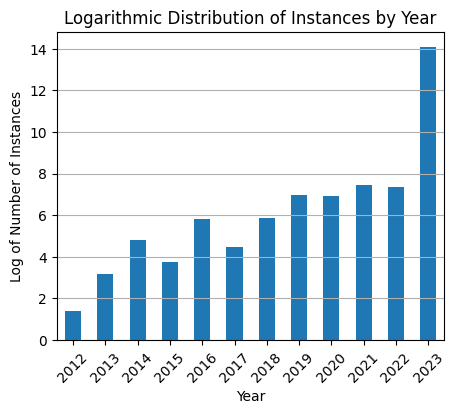

In [93]:
plot_instances_distribution_by_year(df=metadata, datetime_column='VT_LAST_ANALYSIS_DATE')

In [107]:
filter_dataset_sha256 = get_intersection(df1=dataset_sha256, df2=metadata, column='SHA256')
index_sha256 = filter_dataset_sha256.index
filter_dataset_sha256

,SHA256
0,FF739CB6B744C3A19108694DFC920C839CE2E2CB66BFE6...
1,FF739DC276AAC3EEA52D0270B0BB2D7BA51778A75FAB44...
2,FF739E1EC582AA85E591BB84427847A2B7BA1B98469396...
3,FF739EAC59AD8C4D43B9AFC0B56D661447F2FA4861D8DC...
4,FF739EEEE25B0670CE6739B91A3558213DD12764A6EC48...
...,...
1348922,F1ECC4473B1E3418D07FB8FAEFCA3DC9696C2B4FFE1840...
1348923,F1ECC45CFDA505F80B1FFF0CA064A0D54BCEA9064A98F9...
1348924,F1ECC46B74AEAEA38E1A002D0E21194CAB1EB2AC889133...
1348925,F1ECC4A96FAB6082949C2F22048813B01F36F8D6ADB0A6...


# Feature Selection

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import feature_selection
from feature_selection import RandomChi2

In [5]:
def load_amex_1m(path, file_name='amex-1M_binary-dataset-[intents-permissions-apicalls].npz'):
    data = np.load(join(path, file_name), allow_pickle=True)
    metadata = dataframe(data['metadata'], columns=data['metadata_columns'])
    
    columns_names = data['column_names']
    sha256 = data['sha256']

    labels_ohe = OneHotEncoder().fit_transform(np.expand_dims(metadata['CLASS'].values, axis=1)).toarray()

    print(data['data'].shape, labels_ohe.shape)
    
    print(metadata['CLASS'].value_counts())

    return data['data'], labels_ohe, metadata, columns_names, sha256


In [6]:
dataset_name = 'amex-1M-[intents-permissions-opcodes-apicalls]'

In [7]:
data, labels_ohe, metadata, columns_names, sha256 = load_amex_1m(
    path=paths['processed'], 
    file_name=f'{dataset_name}.npz'
    )

(1340515, 23247) (1340515, 2)
CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [8]:
metadata['CLASS'].value_counts()

CLASS
0    1221421
1     119094
Name: count, dtype: int64

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(metadata['CLASS'].values)

In [9]:
# Perform chi-square test with k-fold cross-validation
chi2_scores_all, p_values_all = RandomChi2.random_sampling_chi2_test(
    data, 
    y, 
    k_folds=10,
    random_state=0)

Fold 0:
(134052, 23247) (134052,)
Fold 1:
(134052, 23247) (134052,)
Fold 2:
(134052, 23247) (134052,)
Fold 3:
(134052, 23247) (134052,)
Fold 4:
(134052, 23247) (134052,)
Fold 5:
(134051, 23247) (134051,)
Fold 6:
(134051, 23247) (134051,)
Fold 7:
(134051, 23247) (134051,)
Fold 8:
(134051, 23247) (134051,)
Fold 9:
(134051, 23247) (134051,)


In [14]:
chi2_scores_all.shape

(10, 23247)

In [16]:
p_values_all[0]

array([           nan, 1.82872695e-02, 2.73031592e-08, ...,
       1.47271692e-15, 2.81092737e-20, 7.70708011e-17])

In [10]:
# Test the significance of the differences in chi-square scores

p_values_significance = RandomChi2.test_significance(chi2_scores_all)

/home/hendrio/miniconda3/envs/mh/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [17]:
print(p_values_significance)

[       nan 0.72536547 0.95264689 ... 0.21451644 0.13913557 0.2212527 ]


# CHI2 Features

In [23]:
mh100_chi2 = pd.read_csv(join(paths['resources'], 'mh100_chi2.csv'))
mh100_chi2
# mh100_chi2 = modify_column(df=mh100_chi2, column='names', feature_name='intent')
# mh100_chi2 = modify_column(df=mh100_chi2, column='names', feature_name='permission')
# mh100_chi2 = modify_column(df=mh100_chi2, column='names', feature_name='apicall')
# mh100_chi2


,Unnamed: 0,names,stats,p_values
0,0,permissions::mount::unmount::filesystems,22321.011249,0.000000
1,1,permissions::change::wifi::state,17168.829776,0.000000
2,2,permissions::get::tasks,16600.018340,0.000000
3,3,intents::package::removed,16365.160445,0.000000
4,4,permissions::change::network::state,15538.667462,0.000000
...,...,...,...,...
12530,12530,apicalls::landroid/widget/horizontalscrollview...,3.846674,0.049845
12531,12531,apicalls::landroid/widget/multiautocompletetex...,3.846674,0.049845
12532,12532,apicalls::landroid/nfc/cardemulation/cardemula...,3.844322,0.049915
12533,12533,apicalls::landroid/widget/listview.computevert...,3.843878,0.049928


In [ ]:
apicalls_chi2 = mh100_chi2[mh100_chi2['names'].str.contains('apicalls::')].drop(columns=['index'])
apicalls_chi2

In [13]:
amex_data.head()

,apicalls::landroid/bluetooth/bluetootha2dp.getconnecteddevices,apicalls::landroid/bluetooth/bluetootha2dp.getconnectionstate,apicalls::landroid/bluetooth/bluetootha2dp.getdevicesmatchingconnectionstates,apicalls::landroid/bluetooth/bluetootha2dp.isa2dpplaying,apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery,apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress,apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy,apicalls::landroid/bluetooth/bluetoothadapter.disable,apicalls::landroid/bluetooth/bluetoothadapter.enable,apicalls::landroid/bluetooth/bluetoothadapter.getaddress,...,apicalls::landroid/widget/zoomcontrols.setvisibility,apicalls::landroid/widget/zoomcontrols.setzoomspeed,apicalls::landroid/widget/zoomcontrols.show,apicalls::landroid/window/splashscreen.setonexitanimationlistener,apicalls::landroid/window/splashscreen.setsplashscreentheme,apicalls::landroid/window/splashscreenview.geticonanimationduration,apicalls::landroid/window/splashscreenview.geticonanimationstart,apicalls::landroid/window/splashscreenview.geticonview,apicalls::landroid/window/splashscreenview.getrootview,apicalls::landroid/window/splashscreenview.remove
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
amex_metadata.head()

,VT_LAST_ANALYSIS_DATE,VT_SIZE,SHA256,VT_MD5,VT_TIMES_SUBMITTED,VT_SCANNERS_FAILURE,VT_SCANNERS_MALICIOUS,VT_SCANNERS_UNDETECTED,VT_SCANNERS_SUGGESTED_THREAT_LABEL,VT_SCANNERS_NAMES,CLASS
0,2023-08-05 21:15:13,15576052.0,F0CCCE784B9CCE014B49D309373A64445994EBFBCCA59D...,d90c42db8299e0a8f4504580be3bdfc5,2,3,1,37,NaN,['SymantecMobileInsight'],0
1,2023-08-05 21:13:27,16874953.0,F0CCCEE4372536479010C93A63A7CF5A0C17DC147A88F6...,79cae7482063815784795b231822c8a8,1,0,0,64,NaN,[],0
2,2023-08-05 21:14:38,5366555.0,F0CCCFE09C1B6F4554F0786E23FEB706E320482D99B0E6...,3a75ebeda8ed1f49be929c8e5f28d59c,2,2,0,53,NaN,[],0
3,2023-08-05 21:09:19,4906525.0,F0CCD0627E09CF006004878283B24A763CE9703E2D91CD...,0a31f7d965e26a9c88615e95cadc0790,2,0,10,55,trojan.jiagu,"['Zillya', 'K7GW', 'Trustlook', 'SymantecMobil...",1
4,2023-08-05 21:09:53,19142337.0,F0CCD2984D49D859DA890814B30C35EFC4E4DDA23D78C6...,3d9bad0aa2c8c1d5ba1113ffcb794ca9,1,2,0,62,NaN,[],0


In [14]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return np.asarray(lst3)

In [15]:
filtered_apicalls = intersection(lst1=amex_data.columns.values, lst2=apicalls_chi2['names'].values)
print(filtered_apicalls.shape)

(11556,)


In [22]:
dataframe(amex_data.columns.intersection(filtered_apicalls).values, columns=['apicalls']).to_csv(join(paths['resources'], 'filtered_apicalls_chi2.csv'))

In [16]:
apicalls_chi2_data = amex_data[amex_data.columns.intersection(filtered_apicalls)]
apicalls_chi2_data

,apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery,apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress,apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy,apicalls::landroid/bluetooth/bluetoothadapter.disable,apicalls::landroid/bluetooth/bluetoothadapter.enable,apicalls::landroid/bluetooth/bluetoothadapter.getaddress,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothleadvertiser,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothlescanner,apicalls::landroid/bluetooth/bluetoothadapter.getbondeddevices,apicalls::landroid/bluetooth/bluetoothadapter.getdefaultadapter,...,apicalls::landroid/widget/zoomcontrols.getvisibility,apicalls::landroid/widget/zoomcontrols.layout,apicalls::landroid/widget/zoomcontrols.ontouchevent,apicalls::landroid/widget/zoomcontrols.removeallviews,apicalls::landroid/widget/zoomcontrols.setiszoominenabled,apicalls::landroid/widget/zoomcontrols.setiszoomoutenabled,apicalls::landroid/widget/zoomcontrols.setonzoominclicklistener,apicalls::landroid/widget/zoomcontrols.setonzoomoutclicklistener,apicalls::landroid/widget/zoomcontrols.setvisibility,apicalls::landroid/widget/zoomcontrols.setzoomspeed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1340511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1340512,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1340513,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
apicalls_chi2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340515 entries, 0 to 1340514
Columns: 11556 entries, apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery to apicalls::landroid/widget/zoomcontrols.setzoomspeed
dtypes: int8(11556)
memory usage: 14.4 GB


In [24]:
dataset_name = 'amex-1M-[apicalls]-chi2'

In [25]:
np.savez_compressed(
    join(paths['processed'], f'{dataset_name}'), 
    data=apicalls_chi2_data.values,
    column_names =  apicalls_chi2_data.columns.values,
    metadata=amex_metadata.values,
    metadata_columns = amex_metadata.columns.values,
    classes =  amex_metadata['CLASS'].values,
    sha256 = amex_metadata['SHA256'].values
    )